In [1]:
## conda env Weather_Prediction

import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import pearsonr

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error

import shap
import os
import geopandas as gpd

In [2]:
## load the data

full_df = pd.read_pickle("2010_data.pkl")
full_df=full_df.drop(columns=['location_name', 'fips', 'year', 'NAME', 'geometry'],axis=1)
pd.set_option('display.max_columns', None)
full_df

,MeanLifeExpectency,d2m,t2m,bcaod550,chnk,duaod550,lai_hv,lai_lv,msl,omaod550,pm2p5,pm10,ssaod550,asn,rsn,sd,suaod550,sp,tsn,aod550,tcco,tc_c2h6,tchcho,tc_oh,tc_c5h8,tc_ch4,tc_hno3,tcno2,tc_no,gtco3,tc_pan,tc_c3h8,tcso2,tcw,tcwv,aermssdus,aermssdum,aermssdul,aermssbchphil,aermssomhphil,aermssbchphob,aermssomhphob,aermsssss,aermssssm,aermssssl,aermsssu,aermssso2
0,75.728489,283.454410,291.089093,0.006284,0.01800,0.010721,3.928873,2.633910,101693.509736,0.075966,1.445389e-08,1.981001e-08,0.007574,0.878745,271.096109,0.005542,0.071412,100187.304165,272.665101,0.171956,0.000890,0.000003,4.351195e-06,4.876012e-09,3.973694e-06,0.009891,0.000005,0.000003,4.658415e-07,0.006583,0.000009,6.953380e-07,2.916594e-06,25.766945,25.620820,2.109251e-06,4.289945e-06,3.297524e-06,1.285140e-07,0.000003,5.390907e-07,0.000013,2.305156e-07,0.000016,1.011381e-06,0.000008,1.620365e-06
1,77.826608,286.767193,292.241782,0.006410,0.01527,0.013597,3.930011,2.508253,101685.471788,0.072641,1.346257e-08,1.847324e-08,0.010417,0.879538,193.698250,0.004818,0.069880,101309.280631,275.408300,0.172946,0.000875,0.000003,3.513297e-06,4.926652e-09,2.062545e-06,0.010006,0.000005,0.000003,4.380713e-07,0.006433,0.000008,6.623504e-07,2.408668e-06,27.838995,27.701486,2.641386e-06,5.453165e-06,4.363785e-06,1.200844e-07,0.000002,5.609629e-07,0.000013,2.891494e-07,0.000021,2.088636e-06,0.000008,1.140217e-06
2,75.841973,284.124711,291.030084,0.006434,0.01800,0.010576,4.154440,2.339233,101690.626048,0.073790,1.528844e-08,2.094088e-08,0.007874,0.879026,245.431868,0.006236,0.067283,100229.513473,272.708199,0.165957,0.000885,0.000003,4.161191e-06,4.878442e-09,3.484876e-06,0.009897,0.000005,0.000003,4.412445e-07,0.006521,0.000009,6.841318e-07,2.561723e-06,26.076443,25.936913,2.072566e-06,4.220296e-06,3.329836e-06,1.460098e-07,0.000002,5.375428e-07,0.000013,2.383421e-07,0.000016,1.124706e-06,0.000008,1.212712e-06
3,73.705432,283.448675,290.734945,0.006233,0.01800,0.010422,3.859579,2.695780,101696.274163,0.077023,1.467121e-08,2.014099e-08,0.007201,0.878604,274.363643,0.005314,0.073008,100215.778699,272.652578,0.173887,0.000894,0.000003,4.369584e-06,4.879895e-09,3.844808e-06,0.009893,0.000005,0.000004,5.053737e-07,0.006622,0.000009,7.044878e-07,3.263775e-06,25.607194,25.458810,2.049331e-06,4.173433e-06,3.204589e-06,1.257123e-07,0.000003,5.365352e-07,0.000013,2.220161e-07,0.000015,9.132320e-07,0.000008,1.971961e-06
4,75.753407,282.868247,289.766565,0.006107,0.01800,0.008332,3.234586,2.781183,101710.006570,0.077158,1.519334e-08,2.097774e-08,0.006178,0.877193,276.665988,0.006156,0.074710,99027.783845,272.614234,0.172485,0.000889,0.000003,4.043741e-06,4.893173e-09,2.631260e-06,0.009770,0.000005,0.000004,5.254242e-07,0.006689,0.000009,7.188703e-07,3.696579e-06,24.042930,23.889293,1.644247e-06,3.319324e-06,2.564080e-06,1.292652e-07,0.000003,5.195765e-07,0.000013,1.988160e-07,0.000013,7.093172e-07,0.000008,2.447597e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3122,77.582422,268.842111,278.301219,0.004760,0.01800,0.004101,2.370862,0.499930,101630.449624,0.043633,7.253336e-09,1.103061e-08,0.005092,0.798388,288.873684,0.016426,0.023886,78530.596578,268.911264,0.081471,0.000644,0.000003,1.057299e-06,4.941603e-09,8.047194e-08,0.007655,0.000003,0.000002,4.937694e-07,0.006915,0.000005,5.093373e-07,1.734801e-06,7.928388,7.855770,5.407217e-07,1.250976e-06,3.762784e-06,9.304454e-08,0.000002,4.126463e-07,0.000008,2.043045e-07,0.000013,9.202822e-07,0.000003,1.312529e-06
3123,83.771012,267.887551,274.410086,0.004909,0.01800,0.001664,2.481296,2.428177,101634.772736,0.046080,6.861324e-09,9.790676e-09,0.006100,0.807739,305.402204,0.095034,0.021758,75497.845779,268.751272,0.080511,0.000615,0.000003,8.352510e-07,4.851321e-09,7.964809e-08,0.007339,0.000003,0.000001,2.701267e-07,0.007030,0.000004,4.969263e-07,5.508047e-07,6.659885,6.563536,2.826886e-07,6.105456e

In [3]:
## Lets create a Train-Test set

features=full_df.drop('MeanLifeExpectency',axis=1)
target=full_df['MeanLifeExpectency'].copy()

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20) 

In [4]:
## initial results

forest_reg=RandomForestRegressor()
forest_reg.fit(X_train, y_train)

train_prediction=forest_reg.predict(X_train)

mse_train=mean_squared_error(y_train, train_prediction)
rmse_train=np.sqrt(mse_train)
rmse_train=int(rmse_train*100)/100 ## display only two digits without rounding

print('The train RMSE :::', '%.2f' % rmse_train)

The train RMSE ::: 0.54


In [5]:
## lets do a cross-validation to identify overfitting and test if there is variation in the output result,
## based on variability of the input data

scores=cross_val_score(forest_reg, X_train, y_train,
                        scoring='neg_mean_squared_error', cv=4, n_jobs=6) ## can select other scoring as well
                                                                          ## n_jobs uses the number of cores
rmse_scores=np.sqrt(-scores)
sd_rmse=rmse_scores.std()
avg_score=rmse_scores.mean()


In [6]:
print(f'RMSE scores for each fold: {rmse_scores}')
print(f'Mean RMSE score: {avg_score}')
print(f'Standard deviation of RMSE scores: {sd_rmse}')


RMSE scores for each fold: [1.42794826 1.40057974 1.55621407 1.56008876]
Mean RMSE score: 1.4862077067883845
Standard deviation of RMSE scores: 0.07260442906961882


In [7]:
%%time
## lets optimize the hyperparameters
forest_reg=RandomForestRegressor(n_jobs=-1, oob_score=True) ## also include oob score. this can be removed if not necessary

hyper_parameters=[{'n_estimators':[80,90,100,110,120,150], 'max_features': [6,8,10,12,15], 'max_depth':[100, 150, 200],
                                                              'min_samples_split':[5, 10, 20]}]
grid_search=GridSearchCV(forest_reg,hyper_parameters,cv=4,scoring="neg_mean_squared_error",return_train_score=True, verbose=1)
grid_search.fit(X_train,y_train)

Fitting 4 folds for each of 270 candidates, totalling 1080 fits
CPU times: total: 36min 25s
Wall time: 6min 37s


GridSearchCV(cv=4, estimator=RandomForestRegressor(n_jobs=-1, oob_score=True),
             param_grid=[{'max_depth': [100, 150, 200],
                          'max_features': [6, 8, 10, 12, 15],
                          'min_samples_split': [5, 10, 20],
                          'n_estimators': [80, 90, 100, 110, 120, 150]}],
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [8]:
grid_search.best_estimator_

RandomForestRegressor(max_depth=200, max_features=10, min_samples_split=5,
                      n_estimators=150, n_jobs=-1, oob_score=True)

In [9]:
## lets now select the model. This will be used later
final_model=grid_search.best_estimator_

In [10]:
## fit the model and find the error in the traning set

final_model.fit(X_train,y_train)

train_prediction=final_model.predict(X_train)

mse_train=mean_squared_error(y_train, train_prediction)
rmse_train=np.sqrt(mse_train)
rmse_train=int(rmse_train*100)/100 ## display only two digits without rounding

print('The train RMSE :::', '%.2f' % rmse_train)

The train RMSE ::: 0.66


In [11]:
oob_score=final_model.oob_score_
print(f'OOB score is: {oob_score:.2}') ## oob_score_ is calucalated as R$^2$ between true and estimated 

OOB score is: 0.63


In [12]:
## The test prediction

test_prediction=final_model.predict(X_test)

mse_test=mean_squared_error(y_test,test_prediction)
rmse_test=np.sqrt(mse_test)
rmse_test=int(rmse_test*100)/100 

print('The test RMSE :::', '%.2f' % rmse_test)

The test RMSE ::: 1.33


In [13]:
## the train r square

train_r_sq=(pearsonr(y_train,train_prediction)[0])**2
corr_train=int(train_r_sq*100)/100 ## display only two digits without rounding

print('The train r_sq :::', '%.2f' % corr_train)

The train r_sq ::: 0.93


In [14]:
## The test r square

test_r_sq=(pearsonr(y_test,test_prediction)[0])**2
corr_test=int(test_r_sq*100)/100 ## display only two digits without rounding

print('The test r_sq :::', '%.2f' % corr_test)

The test r_sq ::: 0.66


In [15]:
## calculate the adjusted r square

## in training set

n_train=X_train.shape[0] ## number of samples in training set
n_test=X_test.shape[0]  ## number of samples in test set
p=X_train.shape[1] ## number of features, which is the same in train and test set

train_adjusted_r2=1-(1-corr_train)*((n_train-1)/(n_train-p-1))
train_adjusted_r2=int(train_adjusted_r2*100)/100 ## display only two digits without rounding

test_adjusted_r2=1-(1-corr_test)*((n_test-1)/(n_test-p-1))
test_adjusted_r2=int(test_adjusted_r2*100)/100 ## display only two digits without rounding

print('The adjusted train r_sq :::', '%.2f' % train_adjusted_r2)
print('The adjusted test r_sq :::', '%.2f' % test_adjusted_r2)

The adjusted train r_sq ::: 0.92
The adjusted test r_sq ::: 0.63


In [16]:
## steps to convert train and test to pandas dataframe. This step is necessary to plot in seaborn

y_train_np=y_train.to_numpy() ## convert dtype to numpy to plot from seaborn
y_test_np=y_test.to_numpy() 

df1=pd.DataFrame(y_train_np, columns=['Actual'])
df2=pd.DataFrame(train_prediction, columns=['Estimated'])
df3=pd.concat([df1, df2],axis=1)  ## concatenate the columns
df3['Label']='Train'

df4=pd.DataFrame(y_test_np, columns=['Actual'])
df5=pd.DataFrame(test_prediction, columns=['Estimated'])
df6=pd.concat([df4, df5],axis=1)
df6['Label']='Test'

sns_df=pd.concat([df3,df6])

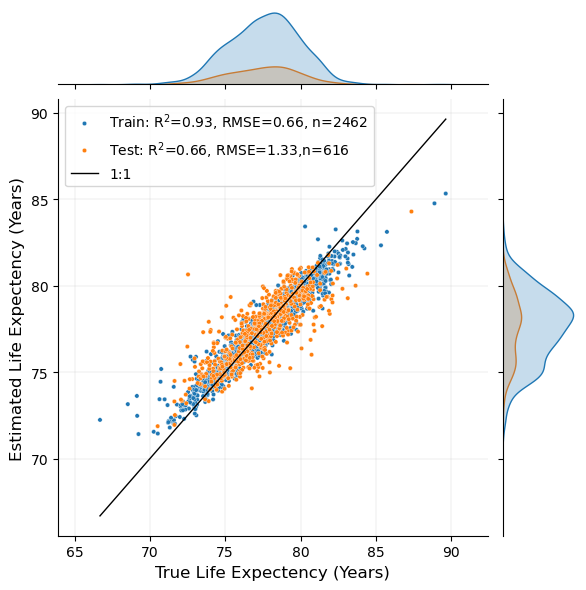

In [17]:
## scatter plot in seaborn

g=sns.jointplot(data=sns_df, x='Actual', y='Estimated', kind="scatter", hue='Label',s=10)
plt.grid(axis='both',linewidth=0.15)

p1 = max(max(train_prediction), max(y_train))
p2 = min(min(train_prediction), min(y_train))

g.ax_joint.plot([p1, p2], [p1, p2], color='k',linewidth=1, label='1:1')

# Customize the legend
handles, labels = g.ax_joint.get_legend_handles_labels()  


g.ax_joint.legend(handles=handles,  labels=[ f'Train: R$^2$={corr_train}, RMSE={rmse_train}, n={len(X_train)}', 
                                             f'Test: R$^2$={corr_test}, RMSE={rmse_test},n={len(X_test)}','1:1'],
                                                                                                        title=None)

g.set_axis_labels(r'True Life Expectency (Years)', r'Estimated Life Expectency (Years)',fontsize=12)

plt.show()

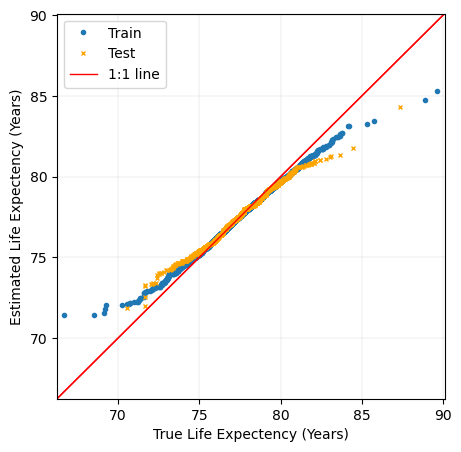

In [18]:
## Lets plot the quantile-quantile plot

fig, ax = plt.subplots(figsize=(5,5))

pp_x = sm.ProbPlot(y_train, fit=False)
pp_y = sm.ProbPlot(train_prediction, fit=False)


qq = pp_y.qqplot(marker='o',markersize=3,other=pp_x,ax=ax, label='Train') ## qq plot for train data
sm.qqline(ax=ax, line='45', fmt='r',linewidth=1)

pp_xx = sm.ProbPlot(y_test, fit=False)
pp_yy = sm.ProbPlot(test_prediction, fit=False)

## overlay qq plot for test data
qqq = pp_yy.qqplot(xlabel='True Life Expectency (Years)',ylabel='Estimated Life Expectency (Years)',
                            marker='x',markersize=3,other=pp_xx,ax=ax,markeredgecolor = 'orange',
                                      markerfacecolor = 'orange', label='Test')

sm.qqline(qq.axes[0], line='45', fmt='r',linewidth=1, label='1:1 line')
plt.grid(axis='both',linewidth=0.15)
plt.legend()
plt.show()

## Find feature importance on the train set

In [19]:
train_permutation = permutation_importance(final_model, X_train, y_train, 
                                            n_jobs=6, ## number of cores to run
                                             n_repeats=9) ## number of times to shuffle, default is 5
train_permutation

{'importances_mean': array([7.70230162e-02, 6.99255987e-02, 2.79651904e-02, 7.78752659e-03,
        7.32642601e-02, 3.99086641e-02, 5.42731281e-02, 1.65267401e-01,
        4.35192761e-02, 2.46716228e-17, 2.46716228e-17, 2.54900119e-02,
        3.99751379e-02, 4.61392222e-02, 2.68166474e-02, 7.29438842e-02,
        2.92425340e-02, 4.56256867e-02, 3.73930584e-02, 3.21696088e-02,
        1.10748989e-04, 1.78345852e-03, 1.23358114e-17, 8.41632487e-03,
        3.67136814e-02, 2.67766948e-03, 9.23434118e-03, 4.46295042e-04,
        4.13979836e-02, 3.68609349e-03, 9.46236820e-05, 4.40366117e-03,
        7.20605377e-02, 5.58772755e-02, 8.27018737e-04, 3.61515899e-03,
        7.74346335e-03, 3.70074342e-17, 2.03569615e-03, 9.97092330e-05,
        7.53028866e-03, 2.78985772e-05, 1.41693406e-02, 3.08690576e-03,
        6.42085354e-03, 4.00464461e-03]),
 'importances_std': array([2.10754864e-03, 2.10926861e-03, 8.34793235e-04, 3.20005992e-04,
        1.57419705e-03, 6.62787018e-04, 1.96601518e-03,

In [20]:
mean_val=train_permutation['importances_mean'] ## mean feature importance
std_value=train_permutation['importances_std'] ## standard deviation after shuffling 9 times
feature_names=X_train.columns  ## get features names

mean_importance=sorted(zip(mean_val, feature_names), reverse=True) 
std_importance=sorted(zip(std_value, feature_names), reverse=True)

In [21]:
mean_val

array([7.70230162e-02, 6.99255987e-02, 2.79651904e-02, 7.78752659e-03,
       7.32642601e-02, 3.99086641e-02, 5.42731281e-02, 1.65267401e-01,
       4.35192761e-02, 2.46716228e-17, 2.46716228e-17, 2.54900119e-02,
       3.99751379e-02, 4.61392222e-02, 2.68166474e-02, 7.29438842e-02,
       2.92425340e-02, 4.56256867e-02, 3.73930584e-02, 3.21696088e-02,
       1.10748989e-04, 1.78345852e-03, 1.23358114e-17, 8.41632487e-03,
       3.67136814e-02, 2.67766948e-03, 9.23434118e-03, 4.46295042e-04,
       4.13979836e-02, 3.68609349e-03, 9.46236820e-05, 4.40366117e-03,
       7.20605377e-02, 5.58772755e-02, 8.27018737e-04, 3.61515899e-03,
       7.74346335e-03, 3.70074342e-17, 2.03569615e-03, 9.97092330e-05,
       7.53028866e-03, 2.78985772e-05, 1.41693406e-02, 3.08690576e-03,
       6.42085354e-03, 4.00464461e-03])

In [22]:
mean_importance

[(0.16526740142191296, 'msl'),
 (0.07702301621544286, 'd2m'),
 (0.07326426012639281, 'duaod550'),
 (0.07294388416990921, 'suaod550'),
 (0.0720605376797203, 'tcw'),
 (0.06992559870579991, 't2m'),
 (0.05587727545780541, 'tcwv'),
 (0.05427312807989235, 'lai_lv'),
 (0.046139222236828696, 'rsn'),
 (0.04562568671060542, 'tsn'),
 (0.04351927611013606, 'omaod550'),
 (0.041397983639832145, 'gtco3'),
 (0.039975137881065534, 'asn'),
 (0.039908664078104165, 'lai_hv'),
 (0.03739305838023252, 'aod550'),
 (0.03671368139763912, 'tc_ch4'),
 (0.03216960882452397, 'tcco'),
 (0.029242534015169408, 'sp'),
 (0.02796519039803511, 'bcaod550'),
 (0.026816647433128876, 'sd'),
 (0.02549001190841491, 'ssaod550'),
 (0.014169340554919018, 'aermssssm'),
 (0.009234341175289837, 'tcno2'),
 (0.008416324867998938, 'tc_c5h8'),
 (0.007787526591147269, 'chnk'),
 (0.007743463350656195, 'aermssdul'),
 (0.007530288656318625, 'aermssomhphob'),
 (0.006420853542457978, 'aermsssu'),
 (0.00440366117044914, 'tcso2'),
 (0.0040046446

In [23]:
std_importance

[(0.005552721050082079, 'msl'),
 (0.002136568493919176, 'suaod550'),
 (0.0021092686081901927, 't2m'),
 (0.0021075486403204667, 'd2m'),
 (0.001966015184439404, 'lai_lv'),
 (0.0016990347845593412, 'tcw'),
 (0.0015741970528152694, 'duaod550'),
 (0.001331489133826918, 'tsn'),
 (0.0010718443872823422, 'asn'),
 (0.0010473630297595943, 'tcco'),
 (0.0010473237354227374, 'gtco3'),
 (0.0010453327937649764, 'aod550'),
 (0.0010347437756245096, 'tcwv'),
 (0.0010085312219190066, 'rsn'),
 (0.0009658018636119699, 'omaod550'),
 (0.0009074100947651068, 'ssaod550'),
 (0.0008481173169547087, 'tc_ch4'),
 (0.0008347932351907639, 'bcaod550'),
 (0.0006627870179640591, 'lai_hv'),
 (0.000596510075616349, 'sp'),
 (0.0005033585209584335, 'sd'),
 (0.0004561978986365273, 'tcno2'),
 (0.00038887655179454275, 'aermssomhphob'),
 (0.00037999856572153195, 'aermssssm'),
 (0.0003529994515718588, 'aermsssu'),
 (0.0003200059924511678, 'chnk'),
 (0.00029167068670857244, 'aermssssl'),
 (0.0002786317802313595, 'aermssdul'),
 (0

In [24]:
mean_imp = pd.DataFrame(mean_val, columns=['Mean Weight'])
std_imp = pd.DataFrame(std_value, columns=['Standard Deviation'])
feature_names=list(features.columns.values) ## get list of features as list
feature_df = pd.DataFrame(feature_names, columns=['Feature'])
train_FI = pd.concat([feature_df,mean_imp, std_imp ], axis=1) 
# Sort in descending order
train_FI = train_FI.sort_values(['Mean Weight'], ascending=[False])

print(train_FI)

          Feature   Mean Weight  Standard Deviation
7             msl  1.652674e-01        5.552721e-03
0             d2m  7.702302e-02        2.107549e-03
4        duaod550  7.326426e-02        1.574197e-03
15       suaod550  7.294388e-02        2.136568e-03
32            tcw  7.206054e-02        1.699035e-03
1             t2m  6.992560e-02        2.109269e-03
33           tcwv  5.587728e-02        1.034744e-03
6          lai_lv  5.427313e-02        1.966015e-03
13            rsn  4.613922e-02        1.008531e-03
17            tsn  4.562569e-02        1.331489e-03
8        omaod550  4.351928e-02        9.658019e-04
28          gtco3  4.139798e-02        1.047324e-03
12            asn  3.997514e-02        1.071844e-03
5          lai_hv  3.990866e-02        6.627870e-04
18         aod550  3.739306e-02        1.045333e-03
24         tc_ch4  3.671368e-02        8.481173e-04
19           tcco  3.216961e-02        1.047363e-03
16             sp  2.924253e-02        5.965101e-04
2        bca

<Axes: xlabel='Mean Weight', ylabel='Feature'>

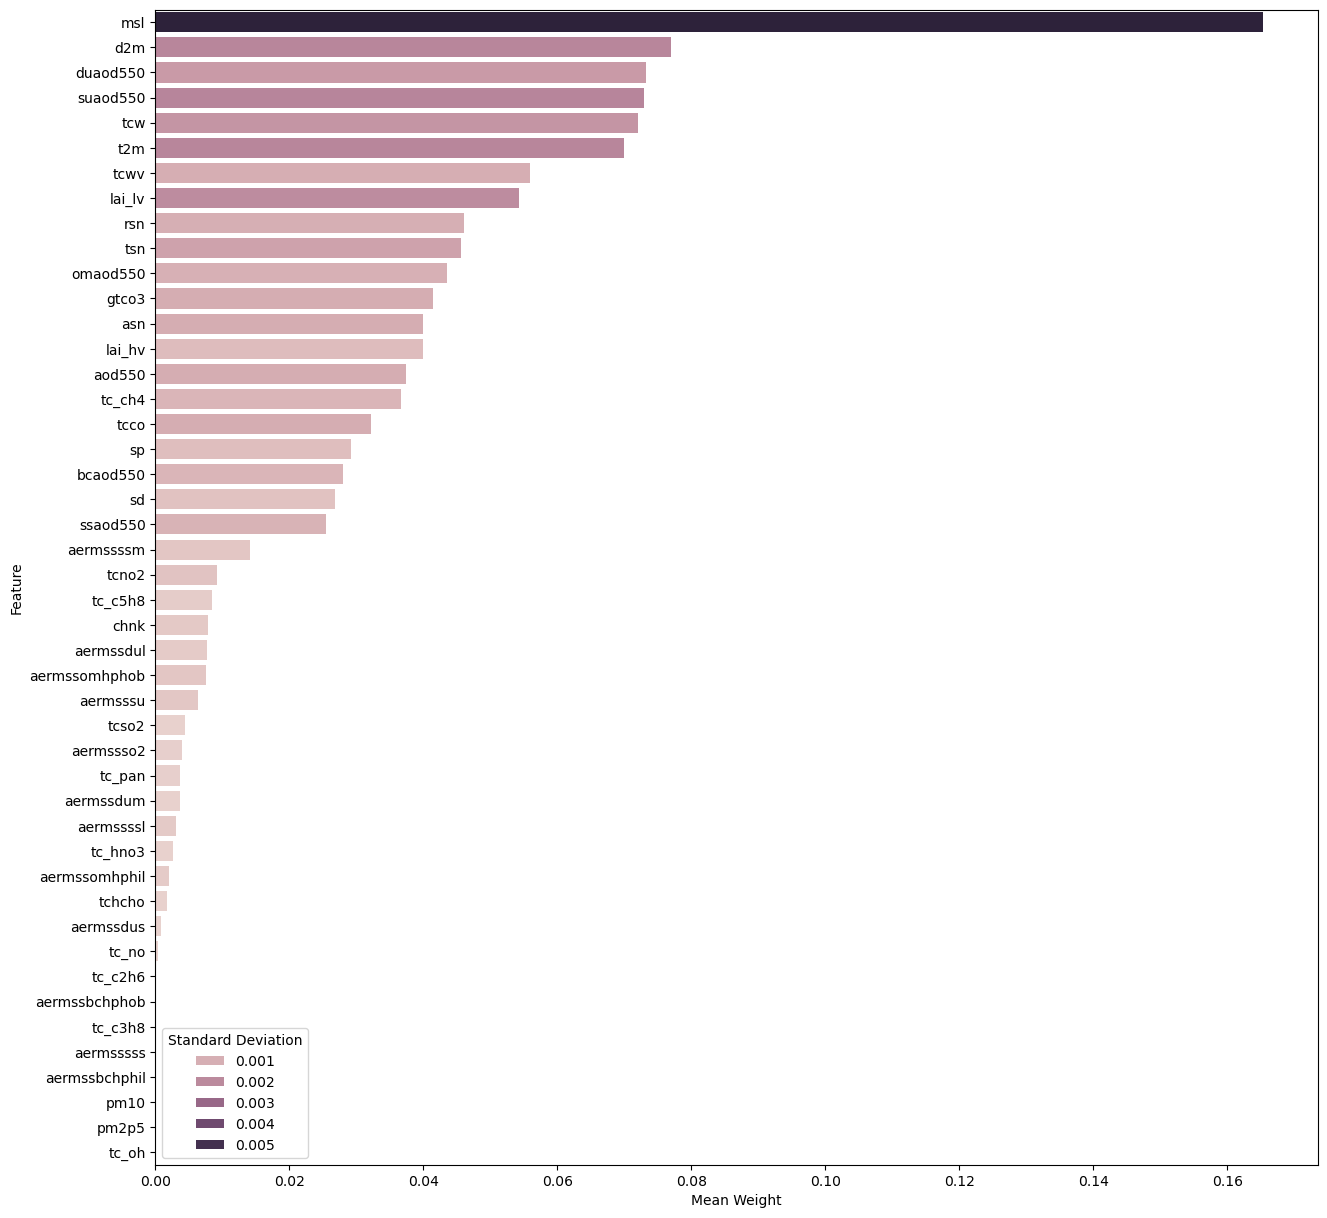

In [25]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.barplot(train_FI, x="Mean Weight", y='Feature', hue='Standard Deviation')

## Find permutation importance in test set

In [26]:
test_permutation = permutation_importance(final_model, X_test, y_test, 
                                            n_jobs=6, ## number of cores to run
                                             n_repeats=9) ## number of times to shuffle, default is 5


<Axes: xlabel='Mean Weight', ylabel='Feature'>

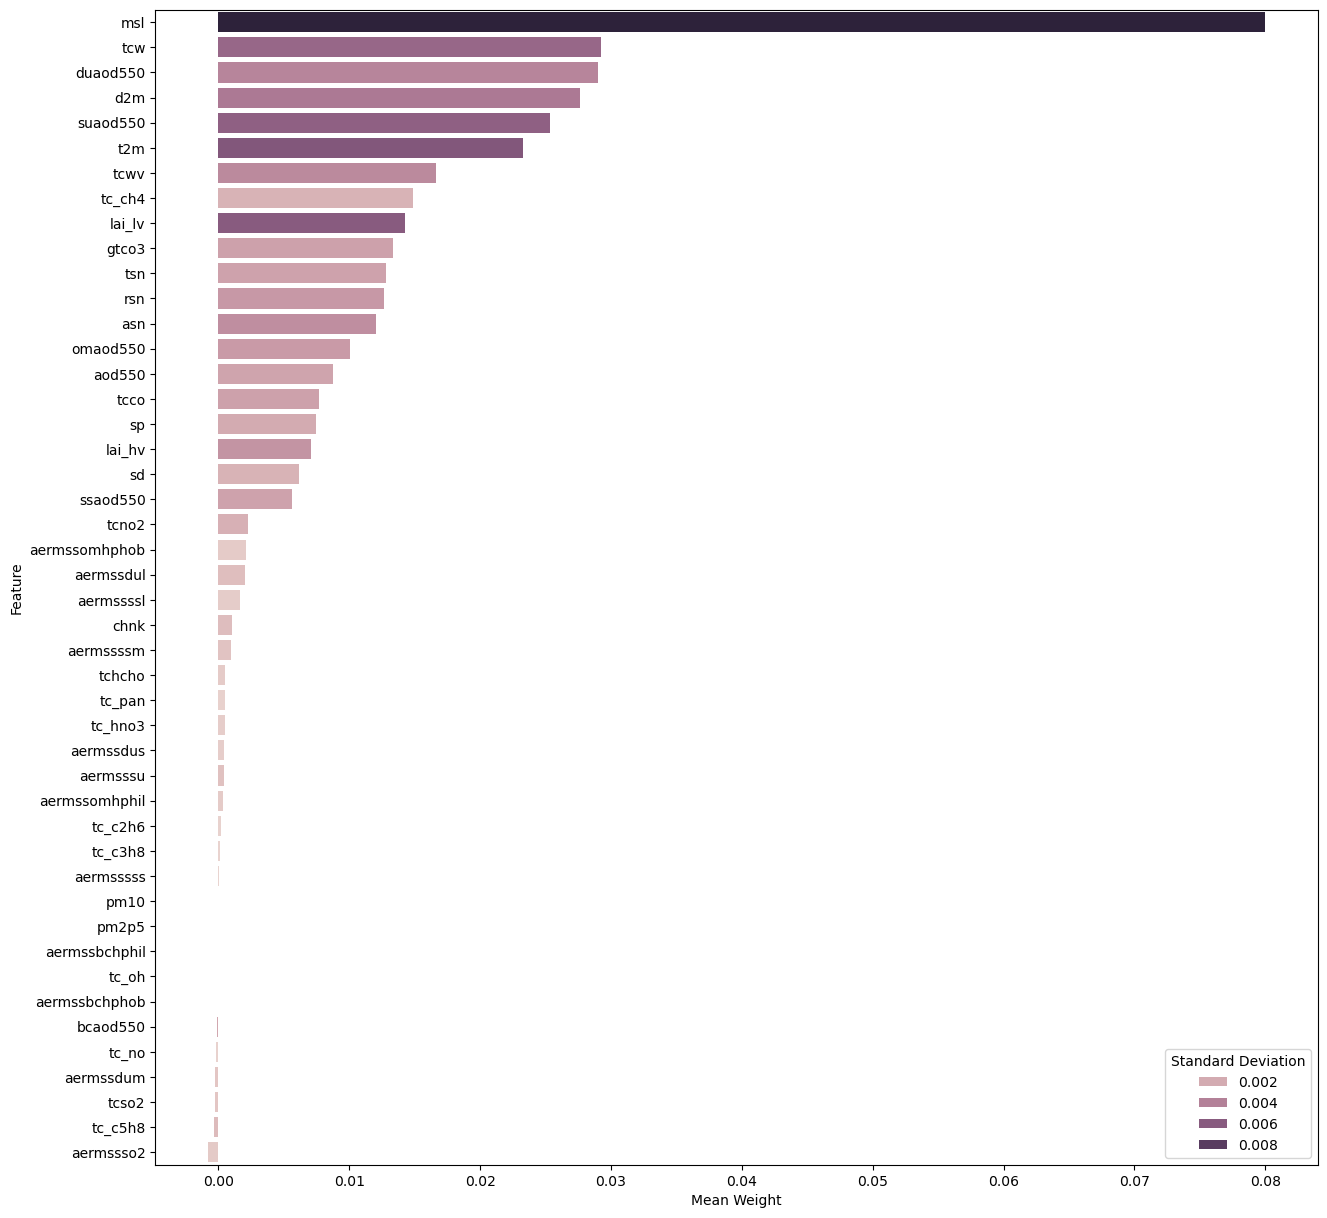

In [27]:
mean_val_test=test_permutation['importances_mean'] ## mean feature importance
std_value_test=test_permutation['importances_std'] ## standard deviation after shuffling 9 times

mean_imp_test = pd.DataFrame(mean_val_test, columns=['Mean Weight'])
std_imp_test = pd.DataFrame(std_value_test, columns=['Standard Deviation'])
feature_names=list(features.columns.values)
feature_df = pd.DataFrame(feature_names, columns=['Feature'])

test_FI = pd.concat([feature_df,mean_imp_test, std_imp_test ], axis=1) 
# Sort in descending order
test_FI = test_FI.sort_values(['Mean Weight'], ascending=[False])

fig, ax = plt.subplots(figsize=(15, 15))
sns.barplot(test_FI, x="Mean Weight", y='Feature', hue='Standard Deviation')

## Find feature importance using SHAP
### This step is necessary because of the Warning sign here https://scikit-learn.org/1.5/modules/permutation_importance.html

In [28]:
## in train set

shap_values = shap.TreeExplainer(final_model).shap_values(X_train)


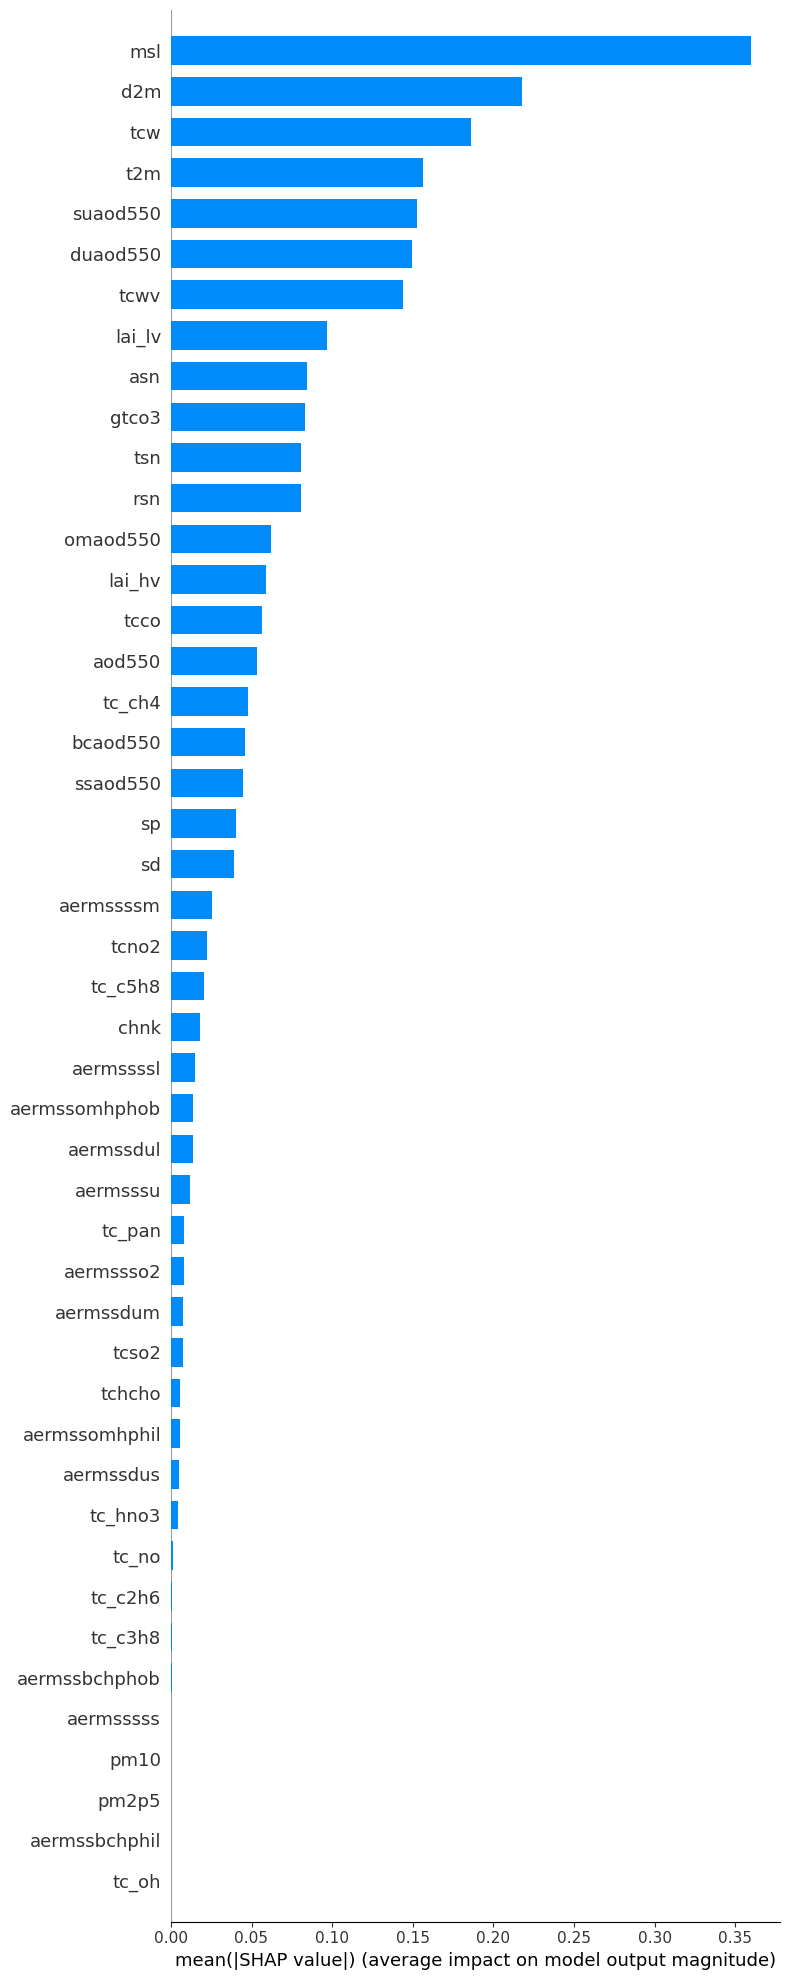

In [29]:
shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=46)
plt.show()

In [30]:
## in test set
shap_values = shap.TreeExplainer(final_model).shap_values(X_test)

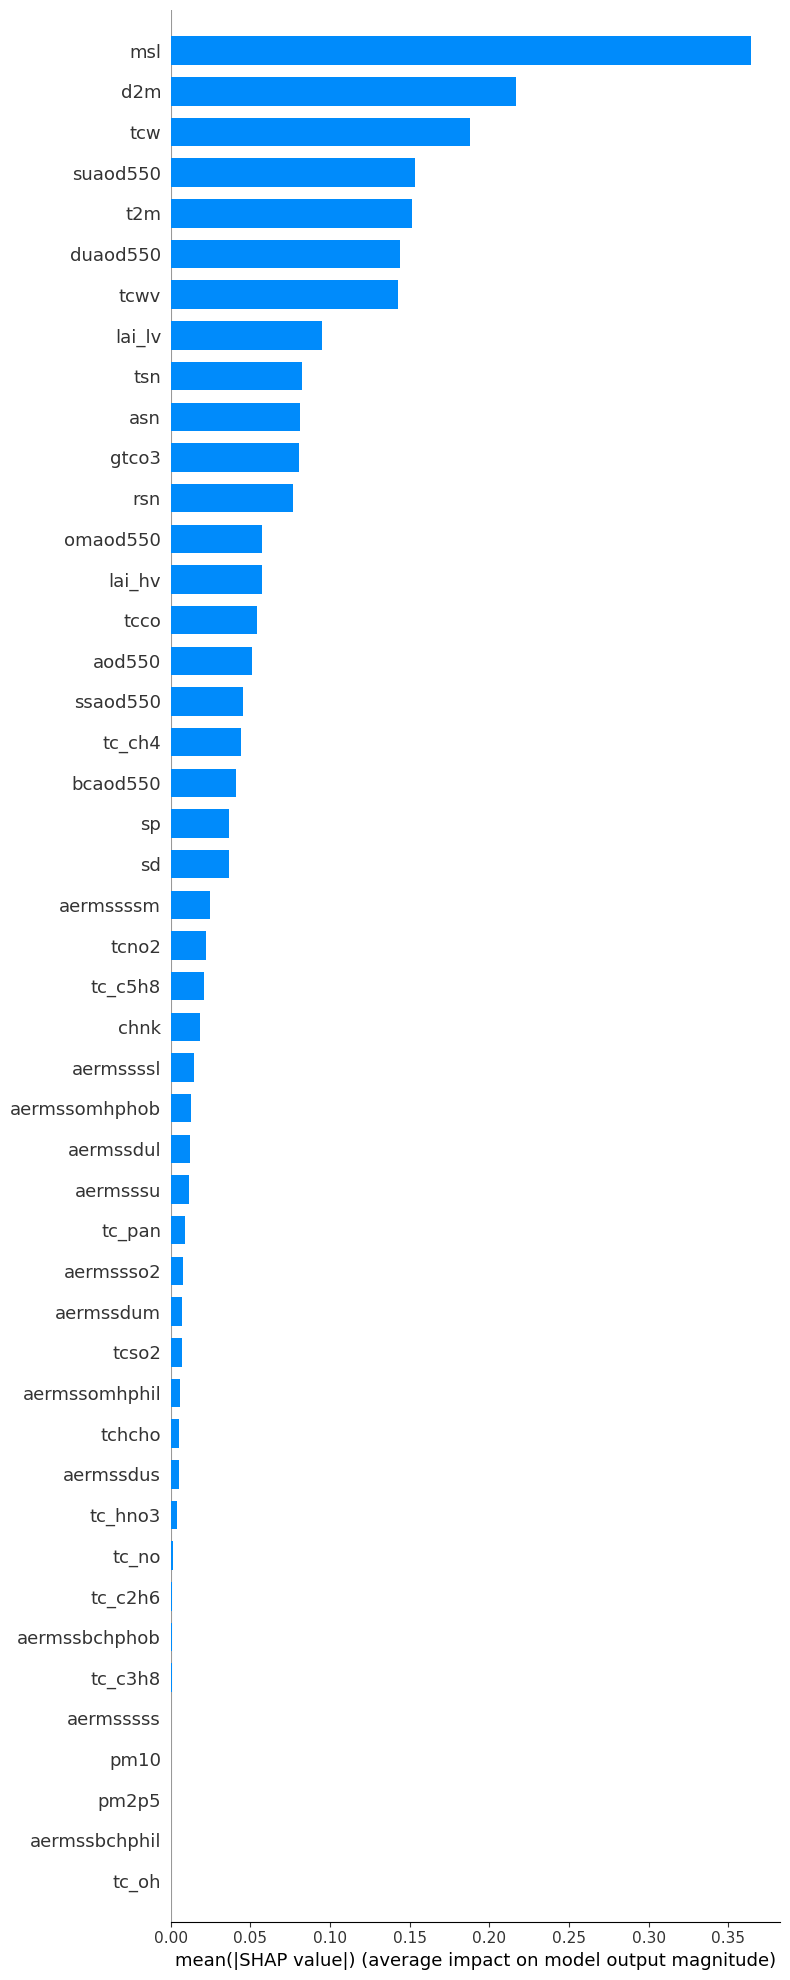

In [31]:
shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=46)
plt.show()

# Plot True Values on a map

In [32]:
##  load the county shapefile

SHAPE_PATH = os.path.join("County_shapefile",'gz_2010_us_050_00_500k.shp')
county_gdf = gpd.read_file(SHAPE_PATH)

county_gdf.head()

,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry
0,0500000US01029,01,029,Cleburne,County,560.100,"POLYGON ((-85.38872 33.91304, -85.38088 33.873..."
1,0500000US01031,01,031,Coffee,County,678.972,"POLYGON ((-86.03044 31.61894, -86.00408 31.619..."
2,0500000US01037,01,037,Coosa,County,650.926,"POLYGON ((-86.00928 33.10164, -86.00917 33.090..."
3,0500000US01039,01,039,Covington,County,1030.456,"POLYGON ((-86.34851 30.99434, -86.35023 30.994..."
4,0500000US01041,01,041,Crenshaw,County,608.840,"POLYGON ((-86.14699 31.68045, -86.14711 31.663..."


In [33]:
## lets create the fips column in the dataframe which is the sum of state and county both as dtype string.
## Note: not a numerical sum
## This step is necessary because there can be several counties with idential names. 

county_gdf['fips']=county_gdf['STATE'] + county_gdf['COUNTY']
county_gdf.dtypes
## convert the data type
county_gdf['fips']=county_gdf['fips'].astype(str).astype(int)
county_gdf.head()

,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry,fips
0,0500000US01029,01,029,Cleburne,County,560.100,"POLYGON ((-85.38872 33.91304, -85.38088 33.873...",1029
1,0500000US01031,01,031,Coffee,County,678.972,"POLYGON ((-86.03044 31.61894, -86.00408 31.619...",1031
2,0500000US01037,01,037,Coosa,County,650.926,"POLYGON ((-86.00928 33.10164, -86.00917 33.090...",1037
3,0500000US01039,01,039,Covington,County,1030.456,"POLYGON ((-86.34851 30.99434, -86.35023 30.994...",1039
4,0500000US01041,01,041,Crenshaw,County,608.840,"POLYGON ((-86.14699 31.68045, -86.14711 31.663...",1041


In [34]:
full_df = pd.read_pickle("2010_data.pkl")
full_df.head(2)

,location_name,fips,year,MeanLifeExpectency,NAME,geometry,d2m,t2m,bcaod550,chnk,duaod550,lai_hv,lai_lv,msl,omaod550,pm2p5,pm10,ssaod550,asn,rsn,sd,suaod550,sp,tsn,aod550,tcco,tc_c2h6,tchcho,tc_oh,tc_c5h8,tc_ch4,tc_hno3,tcno2,tc_no,gtco3,tc_pan,tc_c3h8,tcso2,tcw,tcwv,aermssdus,aermssdum,aermssdul,aermssbchphil,aermssomhphil,aermssbchphob,aermssomhphob,aermsssss,aermssssm,aermssssl,aermsssu,aermssso2
0,Autauga County (Alabama),1001,2010,75.728489,Autauga,"POLYGON ((-86.52469 32.70706, -86.52443 32.707...",283.454410,291.089093,0.006284,0.01800,0.010721,3.928873,2.633910,101693.509736,0.075966,1.445389e-08,1.981001e-08,0.007574,0.878745,271.096109,0.005542,0.071412,100187.304165,272.665101,0.171956,0.000890,0.000003,0.000004,4.876012e-09,0.000004,0.009891,0.000005,0.000003,4.658415e-07,0.006583,0.000009,6.953380e-07,0.000003,25.766945,25.620820,0.000002,0.000004,0.000003,1.285140e-07,0.000003,5.390907e-07,0.000013,2.305156e-07,0.000016,0.000001,0.000008,0.000002
1,Baldwin County (Alabama),1003,2010,77.826608,Baldwin,"POLYGON ((-87.41247 30.57386, -87.41271 30.573...",286.767193,292.241782,0.006410,0.01527,0.013597,3.930011,2.508253,101685.471788,0.072641,1.346257e-08,1.847324e-08,0.010417,0.879538,193.698250,0.004818,0.069880,101309.280631,275.408300,0.172946,0.000875,0.000003,0.000004,4.926652e-09,0.000002,0.010006,0.000005,0.000003,4.380713e-07,0.006433,0.000008,6.623504e-07,0.000002,27.838995,27.701486,0.000003,0.000005,0.000004,1.200844e-07,0.000002,5.609629e-07,0.000013,2.891494e-07,0.000021,0.000002,0.000008,0.000001


In [35]:
true_LE = full_df[['fips', 'MeanLifeExpectency']] ## get only fips and MeanLifeExpectancy column
type(true_LE)

pandas.core.frame.DataFrame

In [36]:
gpd_df = pd.merge(county_gdf, true_LE, on='fips', how='left') 
gpd_df= gpd_df.dropna()
gpd_df.head(2)
## It is VERY IMPORTANT that the left dataframe that is merged is a Geopandas Dataframe
## Not pandas dataframe. While a Geopandas dataframe can be easily plotted, a pandas  
## even if it consists Geometry column, pandas will not recognize it and it will not be plotted

,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry,fips,MeanLifeExpectency
0,0500000US01029,01,029,Cleburne,County,560.100,"POLYGON ((-85.38872 33.91304, -85.38088 33.873...",1029,74.109806
1,0500000US01031,01,031,Coffee,County,678.972,"POLYGON ((-86.03044 31.61894, -86.00408 31.619...",1031,76.675374


In [37]:
## Lets load the shapefile

SHAPE_PATH = os.path.join("State_shapefile",'cb_2018_us_state_500k.shp')
state_shape = gpd.read_file(SHAPE_PATH)

print('The CRS of the SHAPE file is:', state_shape.crs)

The CRS of the SHAPE file is: EPSG:4269


In [38]:
state_shape.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00257 36.52659, -103.00219 36.6..."
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ..."
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.64320 38.16909, -82.64300 38.169..."


In [39]:
## include only CONUS shapefile

remove_state = ['Alaska', 'District of Columbia', 'American Samoa', 'United States Virgin Islands', 'Hawaii', 'Guam', 
                  'Commonwealth of the Northern Mariana Islands', 'Puerto Rico' ]

# Remove rows where the 'NAME' column contains any value from strings
state_shape = state_shape[~state_shape['NAME'].isin(remove_state)]
state_shape.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00257 36.52659, -103.00219 36.6..."
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ..."
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.64320 38.16909, -82.64300 38.169..."


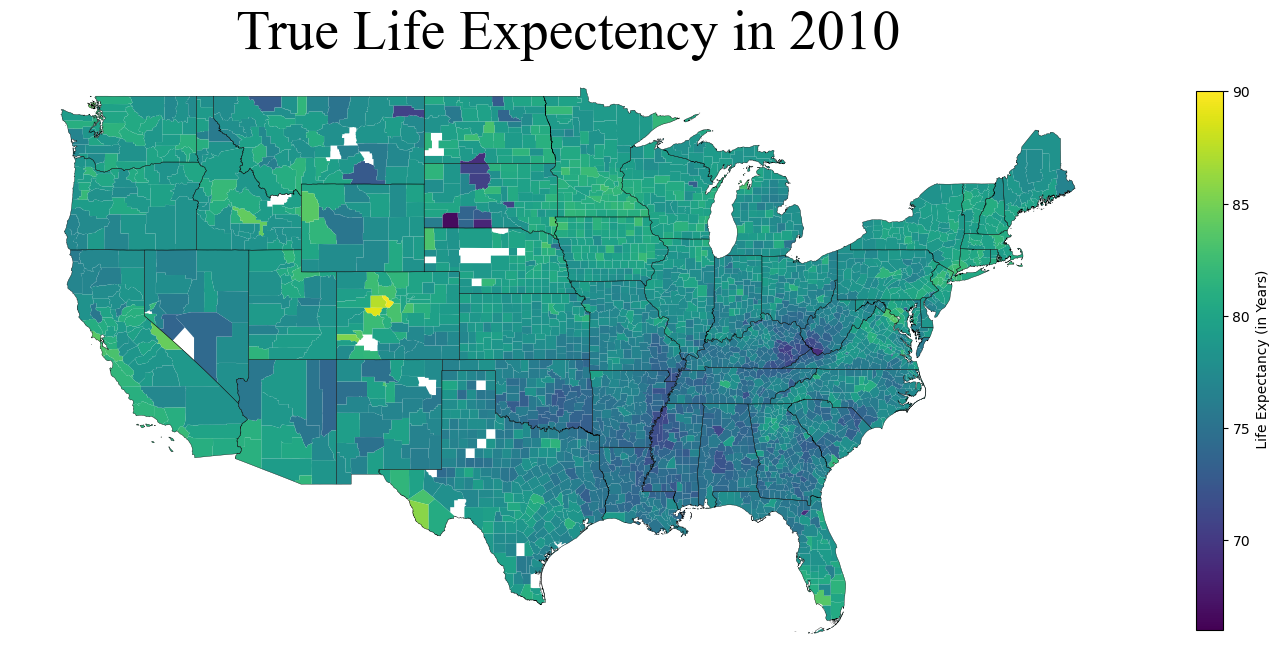

In [40]:
fig, ax = plt.subplots(1, figsize=(18, 14))
ax.axis('off') ## remove axis box from map 


## plot the county shape file
gpd_df.plot(ax=ax,column='MeanLifeExpectency', legend=True, legend_kwds={"label": " Life Expectancy (in Years)", 
                                                                               "shrink":0.50}, vmin=66, vmax=90)
hfont = {'fontname':'Times New Roman'}

## overlay state shapefile
state_shape.plot(facecolor='none', edgecolor='black', ax=ax, linewidth=0.25)

# add a title and annotation
ax.set_title('True Life Expectency in 2010', **hfont, fontdict={'fontsize': '40', 'fontweight' : '1'})

plt.show()

## Plot estimated life expectancy in train and test data

In [41]:
train_prediction

array([78.50654638, 72.02453509, 77.55150445, ..., 78.32976043,
       77.3607854 , 76.40509257])

In [42]:
y_train

1609    78.701834
1063    71.574089
1654    76.745265
3022    76.824460
486     77.555148
          ...    
2725    78.416079
1329    82.802435
2059    79.557175
2662    77.382026
1972    77.343053
Name: MeanLifeExpectency, Length: 2462, dtype: float64

In [43]:
y_train_df=pd.DataFrame([y_train]).T
y_train_df['Train Prediction']=train_prediction
y_train_df

,MeanLifeExpectency,Train Prediction
1609,78.701834,78.506546
1063,71.574089,72.024535
1654,76.745265,77.551504
3022,76.824460,77.025734
486,77.555148,77.427140
...,...,...
2725,78.416079,78.454497
1329,82.802435,82.068908
2059,79.557175,78.329760
2662,77.382026,77.360785


In [44]:
y_test_df=pd.DataFrame([y_test]).T
y_test_df
y_test_df['Test Prediction']=test_prediction
y_test_df

,MeanLifeExpectency,Test Prediction
112,75.544795,78.149355
500,76.413678,76.861485
1210,79.063042,79.589351
1291,79.510822,78.924113
3066,79.040162,79.308476
...,...,...
1560,73.564021,74.759922
1540,77.407791,77.468279
2817,76.467105,76.546620
920,78.245012,77.948399


In [45]:
y_train_df=y_train_df.drop('MeanLifeExpectency', axis=1)
y_test_df=y_test_df.drop('MeanLifeExpectency', axis=1)

In [46]:
df_train = pd.merge(full_df, ## merge index with original data
                    y_train_df, left_index=True, right_index=True, how='left') 
df_train.head()

,location_name,fips,year,MeanLifeExpectency,NAME,geometry,d2m,t2m,bcaod550,chnk,duaod550,lai_hv,lai_lv,msl,omaod550,pm2p5,pm10,ssaod550,asn,rsn,sd,suaod550,sp,tsn,aod550,tcco,tc_c2h6,tchcho,tc_oh,tc_c5h8,tc_ch4,tc_hno3,tcno2,tc_no,gtco3,tc_pan,tc_c3h8,tcso2,tcw,tcwv,aermssdus,aermssdum,aermssdul,aermssbchphil,aermssomhphil,aermssbchphob,aermssomhphob,aermsssss,aermssssm,aermssssl,aermsssu,aermssso2,Train Prediction
0,Autauga County (Alabama),1001,2010,75.728489,Autauga,"POLYGON ((-86.52469 32.70706, -86.52443 32.707...",283.454410,291.089093,0.006284,0.01800,0.010721,3.928873,2.633910,101693.509736,0.075966,1.445389e-08,1.981001e-08,0.007574,0.878745,271.096109,0.005542,0.071412,100187.304165,272.665101,0.171956,0.000890,0.000003,0.000004,4.876012e-09,0.000004,0.009891,0.000005,0.000003,4.658415e-07,0.006583,0.000009,6.953380e-07,0.000003,25.766945,25.620820,0.000002,0.000004,0.000003,1.285140e-07,0.000003,5.390907e-07,0.000013,2.305156e-07,0.000016,1.011381e-06,0.000008,0.000002,75.427891
1,Baldwin County (Alabama),1003,2010,77.826608,Baldwin,"POLYGON ((-87.41247 30.57386, -87.41271 30.573...",286.767193,292.241782,0.006410,0.01527,0.013597,3.930011,2.508253,101685.471788,0.072641,1.346257e-08,1.847324e-08,0.010417,0.879538,193.698250,0.004818,0.069880,101309.280631,275.408300,0.172946,0.000875,0.000003,0.000004,4.926652e-09,0.000002,0.010006,0.000005,0.000003,4.380713e-07,0.006433,0.000008,6.623504e-07,0.000002,27.838995,27.701486,0.000003,0.000005,0.000004,1.200844e-07,0.000002,5.609629e-07,0.000013,2.891494e-07,0.000021,2.088636e-06,0.000008,0.000001,77.095152
2,Barbour County (Alabama),1005,2010,75.841973,Barbour,"POLYGON ((-85.13285 31.80037, -85.13283 31.798...",284.124711,291.030084,0.006434,0.01800,0.010576,4.154440,2.339233,101690.626048,0.073790,1.528844e-08,2.094088e-08,0.007874,0.879026,245.431868,0.006236,0.067283,100229.513473,272.708199,0.165957,0.000885,0.000003,0.000004,4.878442e-09,0.000003,0.009897,0.000005,0.000003,4.412445e-07,0.006521,0.000009,6.841318e-07,0.000003,26.076443,25.936913,0.000002,0.000004,0.000003,1.460098e-07,0.000002,5.375428e-07,0.000013,2.383421e-07,0.000016,1.124706e-06,0.000008,0.000001,75.592853
3,Bibb County (Alabama),1007,2010,73.705432,Bibb,"POLYGON ((-87.11632 32.83560, -87.15529 32.835...",283.448675,290.734945,0.006233,0.01800,0.010422,3.859579,2.695780,101696.274163,0.077023,1.467121e-08,2.014099e-08,0.007201,0.878604,274.363643,0.005314,0.073008,100215.778699,272.652578,0.173887,0.000894,0.000003,0.000004,4.879895e-09,0.000004,0.009893,0.000005,0.000004,5.053737e-07,0.006622,0.000009,7.044878e-07,0.000003,25.607194,25.458810,0.000002,0.000004,0.000003,1.257123e-07,0.000003,5.365352e-07,0.000013,2.220161e-07,0.000015,9.132320e-07,0.000008,0.000002,74.644977
4,Blount County (Alabama),1009,2010,75.753407,Blount,"POLYGON ((-86.73121 34.01470, -86.72710 34.016...",282.868247,289.766565,0.006107,0.01800,0.008332,3.234586,2.781183,101710.006570,0.077158,1.519334e-08,2.097774e-08,0.006178,0.877193,276.665988,0.006156,0.074710,99027.783845,272.614234,0.172485,0.000889,0.000003,0.000004,4.893173e-09,0.000003,0.009770,0.000005,0.000004,5.254242e-07,0.006689,0.000009,7.188703e-07,0.000004,24.042930,23.889293,0.000002,0.000003,0.000003,1.292652e-07,0.000003,5.195765e-07,0.000013,1.988160e-07,0.000013,7.093172e-07,0.000008,0.000002,75.129317


In [48]:
df_train = df_train[['fips', 'Train Prediction']] ## get only fips and train prediction
df_train=df_train.dropna()

In [49]:
plot_train = pd.merge(county_gdf, df_train, on='fips', how='left') 
plot_train= plot_train.dropna()
plot_train.head()

,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry,fips,Train Prediction
1,0500000US01031,01,031,Coffee,County,678.972,"POLYGON ((-86.03044 31.61894, -86.00408 31.619...",1031,76.046964
2,0500000US01037,01,037,Coosa,County,650.926,"POLYGON ((-86.00928 33.10164, -86.00917 33.090...",1037,75.462298
3,0500000US01039,01,039,Covington,County,1030.456,"POLYGON ((-86.34851 30.99434, -86.35023 30.994...",1039,75.126375
4,0500000US01041,01,041,Crenshaw,County,608.840,"POLYGON ((-86.14699 31.68045, -86.14711 31.663...",1041,74.609387
5,0500000US01045,01,045,Dale,County,561.150,"POLYGON ((-85.79043 31.32027, -85.79033 31.323...",1045,76.186665


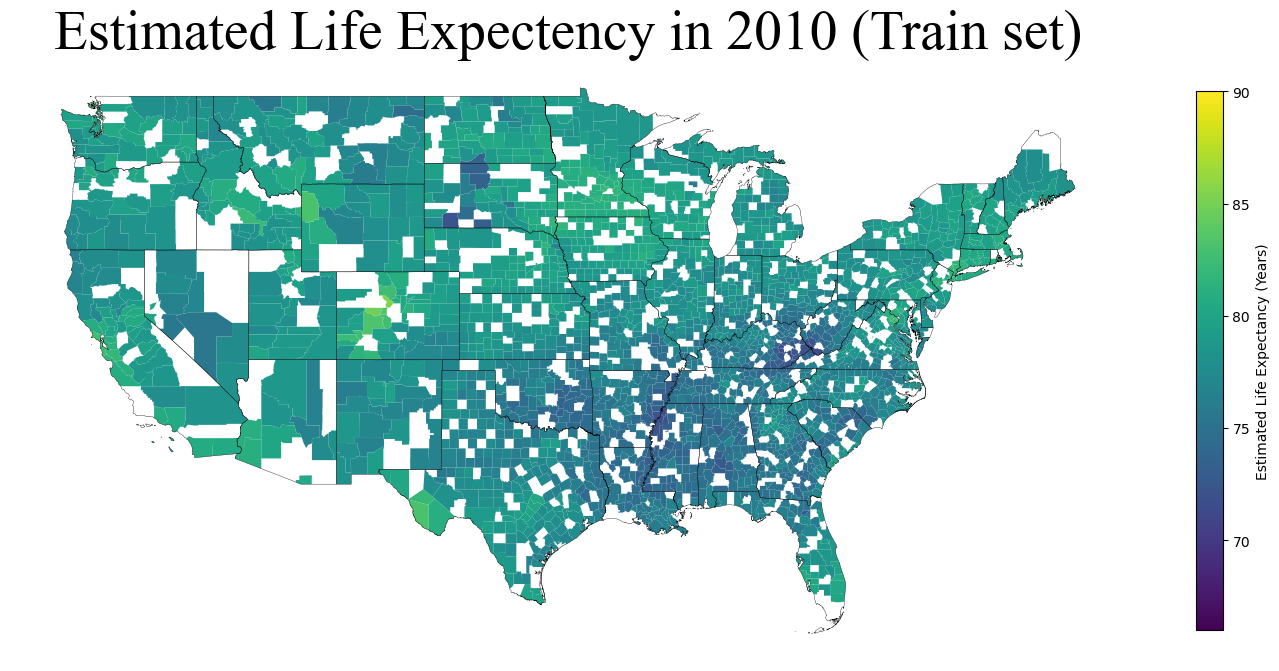

In [55]:
fig, ax = plt.subplots(1, figsize=(18, 14))
ax.axis('off') ## remove axis box from map 


## plot the county shape file
plot_train.plot(ax=ax,column='Train Prediction', legend=True, legend_kwds={"label": "Estimated Life Expectancy (Years)", 
                                                                                   "shrink":0.50}, vmin=66, vmax=90)
hfont = {'fontname':'Times New Roman'}

## overlay state shapefile
state_shape.plot(facecolor='none', edgecolor='black', ax=ax, linewidth=0.25)

# add a title and annotation
ax.set_title('Estimated Life Expectency in 2010 (Train set)', **hfont, fontdict={'fontsize': '40', 'fontweight' : '1'})

plt.show()

In [51]:
df_test = pd.merge(full_df, ## merge index with original data
                    y_test_df, left_index=True, right_index=True, how='left') 
df_test.head()

,location_name,fips,year,MeanLifeExpectency,NAME,geometry,d2m,t2m,bcaod550,chnk,duaod550,lai_hv,lai_lv,msl,omaod550,pm2p5,pm10,ssaod550,asn,rsn,sd,suaod550,sp,tsn,aod550,tcco,tc_c2h6,tchcho,tc_oh,tc_c5h8,tc_ch4,tc_hno3,tcno2,tc_no,gtco3,tc_pan,tc_c3h8,tcso2,tcw,tcwv,aermssdus,aermssdum,aermssdul,aermssbchphil,aermssomhphil,aermssbchphob,aermssomhphob,aermsssss,aermssssm,aermssssl,aermsssu,aermssso2,Test Prediction
0,Autauga County (Alabama),1001,2010,75.728489,Autauga,"POLYGON ((-86.52469 32.70706, -86.52443 32.707...",283.454410,291.089093,0.006284,0.01800,0.010721,3.928873,2.633910,101693.509736,0.075966,1.445389e-08,1.981001e-08,0.007574,0.878745,271.096109,0.005542,0.071412,100187.304165,272.665101,0.171956,0.000890,0.000003,0.000004,4.876012e-09,0.000004,0.009891,0.000005,0.000003,4.658415e-07,0.006583,0.000009,6.953380e-07,0.000003,25.766945,25.620820,0.000002,0.000004,0.000003,1.285140e-07,0.000003,5.390907e-07,0.000013,2.305156e-07,0.000016,1.011381e-06,0.000008,0.000002,NaN
1,Baldwin County (Alabama),1003,2010,77.826608,Baldwin,"POLYGON ((-87.41247 30.57386, -87.41271 30.573...",286.767193,292.241782,0.006410,0.01527,0.013597,3.930011,2.508253,101685.471788,0.072641,1.346257e-08,1.847324e-08,0.010417,0.879538,193.698250,0.004818,0.069880,101309.280631,275.408300,0.172946,0.000875,0.000003,0.000004,4.926652e-09,0.000002,0.010006,0.000005,0.000003,4.380713e-07,0.006433,0.000008,6.623504e-07,0.000002,27.838995,27.701486,0.000003,0.000005,0.000004,1.200844e-07,0.000002,5.609629e-07,0.000013,2.891494e-07,0.000021,2.088636e-06,0.000008,0.000001,NaN
2,Barbour County (Alabama),1005,2010,75.841973,Barbour,"POLYGON ((-85.13285 31.80037, -85.13283 31.798...",284.124711,291.030084,0.006434,0.01800,0.010576,4.154440,2.339233,101690.626048,0.073790,1.528844e-08,2.094088e-08,0.007874,0.879026,245.431868,0.006236,0.067283,100229.513473,272.708199,0.165957,0.000885,0.000003,0.000004,4.878442e-09,0.000003,0.009897,0.000005,0.000003,4.412445e-07,0.006521,0.000009,6.841318e-07,0.000003,26.076443,25.936913,0.000002,0.000004,0.000003,1.460098e-07,0.000002,5.375428e-07,0.000013,2.383421e-07,0.000016,1.124706e-06,0.000008,0.000001,NaN
3,Bibb County (Alabama),1007,2010,73.705432,Bibb,"POLYGON ((-87.11632 32.83560, -87.15529 32.835...",283.448675,290.734945,0.006233,0.01800,0.010422,3.859579,2.695780,101696.274163,0.077023,1.467121e-08,2.014099e-08,0.007201,0.878604,274.363643,0.005314,0.073008,100215.778699,272.652578,0.173887,0.000894,0.000003,0.000004,4.879895e-09,0.000004,0.009893,0.000005,0.000004,5.053737e-07,0.006622,0.000009,7.044878e-07,0.000003,25.607194,25.458810,0.000002,0.000004,0.000003,1.257123e-07,0.000003,5.365352e-07,0.000013,2.220161e-07,0.000015,9.132320e-07,0.000008,0.000002,NaN
4,Blount County (Alabama),1009,2010,75.753407,Blount,"POLYGON ((-86.73121 34.01470, -86.72710 34.016...",282.868247,289.766565,0.006107,0.01800,0.008332,3.234586,2.781183,101710.006570,0.077158,1.519334e-08,2.097774e-08,0.006178,0.877193,276.665988,0.006156,0.074710,99027.783845,272.614234,0.172485,0.000889,0.000003,0.000004,4.893173e-09,0.000003,0.009770,0.000005,0.000004,5.254242e-07,0.006689,0.000009,7.188703e-07,0.000004,24.042930,23.889293,0.000002,0.000003,0.000003,1.292652e-07,0.000003,5.195765e-07,0.000013,1.988160e-07,0.000013,7.093172e-07,0.000008,0.000002,NaN


In [52]:
df_test = df_test[['fips', 'Test Prediction']] ## get only fips and test prediction
df_test=df_test.dropna()

In [53]:
plot_test = pd.merge(county_gdf, df_test, on='fips', how='left') 
plot_test= plot_test.dropna()
plot_test.head()

,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry,fips,Test Prediction
0,0500000US01029,01,029,Cleburne,County,560.100,"POLYGON ((-85.38872 33.91304, -85.38088 33.873...",1029,74.629713
6,0500000US01049,01,049,DeKalb,County,777.093,"POLYGON ((-85.57593 34.82373, -85.56142 34.750...",1049,74.994582
24,0500000US01035,01,035,Conecuh,County,850.156,"POLYGON ((-87.22587 31.26064, -87.28527 31.260...",1035,74.663469
31,0500000US01065,01,065,Hale,County,643.943,"POLYGON ((-87.43736 32.83078, -87.45166 32.830...",1065,74.015268
35,0500000US01087,01,087,Macon,County,608.885,"POLYGON ((-85.85497 32.23200, -85.85889 32.233...",1087,75.462195


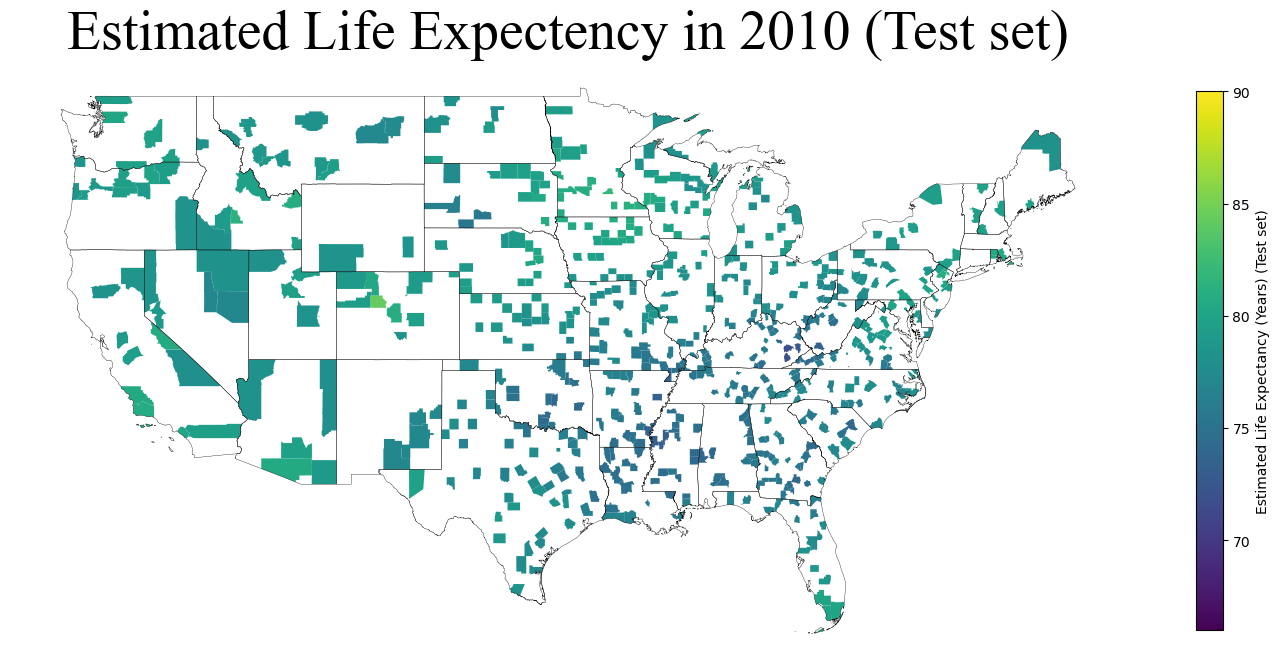

In [56]:
fig, ax = plt.subplots(1, figsize=(18, 14))
ax.axis('off') ## remove axis box from map 


## plot the county shape file
plot_test.plot(ax=ax,column='Test Prediction', legend=True, legend_kwds={"label": "Estimated Life Expectancy (Years) (Test set)", 
                                                                                   "shrink":0.50}, vmin=66, vmax=90)
hfont = {'fontname':'Times New Roman'}

## overlay state shapefile
state_shape.plot(facecolor='none', edgecolor='black', ax=ax, linewidth=0.25)

# add a title and annotation
ax.set_title('Estimated Life Expectency in 2010 (Test set)', **hfont, fontdict={'fontsize': '40', 'fontweight' : '1'})

plt.show()

## Combine train and test set

In [57]:
plot_train=plot_train.rename(columns={"Train Prediction": "Estimated"})
plot_test=plot_test.rename(columns={"Test Prediction": "Estimated"})

final_df=pd.concat([plot_train, plot_test])
final_df = final_df[['fips', 'Estimated']]
final_df

,fips,Estimated
1,1031,76.046964
2,1037,75.462298
3,1039,75.126375
4,1041,74.609387
5,1045,76.186665
...,...,...
3101,55081,79.700993
3114,55129,78.180151
3118,55139,79.219991
3139,56031,78.397594


In [58]:
combined_plot = pd.merge(county_gdf, final_df, on='fips', how='left') 
combined_plot=combined_plot.dropna()

combined_plot

,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry,fips,Estimated
0,0500000US01029,01,029,Cleburne,County,560.100,"POLYGON ((-85.38872 33.91304, -85.38088 33.873...",1029,74.629713
1,0500000US01031,01,031,Coffee,County,678.972,"POLYGON ((-86.03044 31.61894, -86.00408 31.619...",1031,76.046964
2,0500000US01037,01,037,Coosa,County,650.926,"POLYGON ((-86.00928 33.10164, -86.00917 33.090...",1037,75.462298
3,0500000US01039,01,039,Covington,County,1030.456,"POLYGON ((-86.34851 30.99434, -86.35023 30.994...",1039,75.126375
4,0500000US01041,01,041,Crenshaw,County,608.840,"POLYGON ((-86.14699 31.68045, -86.14711 31.663...",1041,74.609387
...,...,...,...,...,...,...,...,...,...
3138,0500000US56027,56,027,Niobrara,County,2626.037,"POLYGON ((-104.05298 42.85955, -104.05286 42.7...",56027,78.711472
3139,0500000US56031,56,031,Platte,County,2084.208,"POLYGON ((-104.77417 42.60996, -104.76422 42.6...",56031,78.397594
3140,0500000US56037,56,037,Sweetwater,County,10426.649,"POLYGON ((-109.05008 41.00066, -109.17368 41.0...",56037,78.379788
3141,0500000US56043,56,043,Washakie,County,2238.549,"POLYGON ((-107.12892 43.99455, -107.12797 43.9...",56043,77.956192


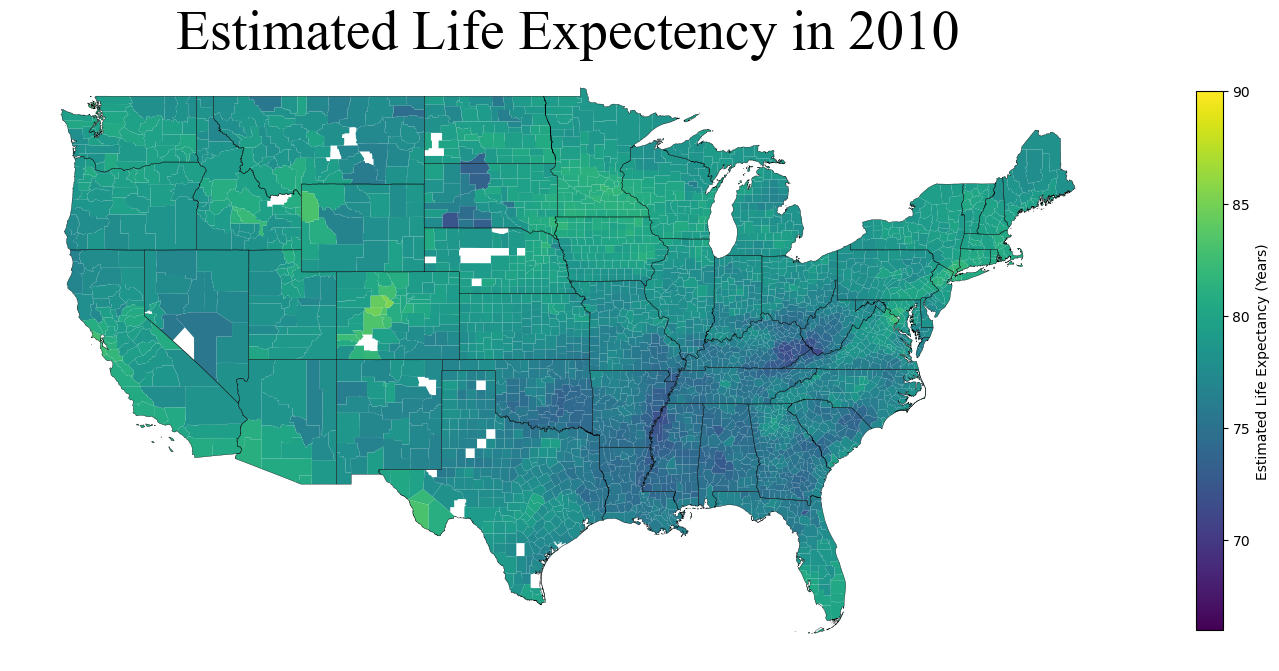

In [59]:
fig, ax = plt.subplots(1, figsize=(18, 14))
ax.axis('off') ## remove axis box from map 


## plot the county shape file
combined_plot.plot(ax=ax,column='Estimated', legend=True, legend_kwds={"label": "Estimated Life Expectancy (Years)", 
                                                                                   "shrink":0.50}, vmin=66, vmax=90)
hfont = {'fontname':'Times New Roman'}

## overlay state shapefile
state_shape.plot(facecolor='none', edgecolor='black', ax=ax, linewidth=0.25)

# add a title and annotation
ax.set_title('Estimated Life Expectency in 2010', **hfont, fontdict={'fontsize': '40', 'fontweight' : '1'})

plt.show()